### Job Shop Problem
The following notebook contains the solution for [googles example JSP](https://developers.google.com/optimization/scheduling/job_shop) with some notes for clarity

In [107]:
import collections
from ortools.sat.python import cp_model

In [108]:
jobs_data = [  # task = (machine_id, processing_time).
    [(0, 3), (1, 2), (2, 2)],  # Job0
    [(0, 2), (2, 1), (1, 4)],  # Job1
    [(1, 4), (2, 3)],  # Job2
]

In [109]:
machines_count = 1 + max(task[0] for job in jobs_data for task in job)
all_machines = range(machines_count)
# Computes horizon dynamically as the sum of all durations.
# Horizon means the maximum time span of the problem.
horizon = sum(task[1] for job in jobs_data for task in job)
horizon

21

In [110]:
model = cp_model.CpModel()

In [111]:
# Named tuple to store information about created variables.
task_type = collections.namedtuple("task_type", "start end interval")

# Named tuple to manipulate solution information.
assigned_task_type = collections.namedtuple(
    "assigned_task_type", "start job index duration"
)

### Adding variables
For each task, we add three variables:

- **start_var** describes the start time of the task
- **end_var** describes the end time for the task
- **interval_var** is used to define the temporal relationship of start_var and end_var. start_var must be before end_var and with a fixed distance (duration) between them

The purpose of interval variables in OR-Tools' CpModel is to ensure that the start and end times of tasks, along with their durations, are properly aligned and respected during the solving process.

#### Why do we store information in all_tasks and machine_to_intervals?
By storing each task's start, end, and interval variables in all_tasks, we can easily access and reference these variables later when adding constraints, monitoring, or retrieving solved values.


Organizing tasks by machine in machine_to_intervals helps in managing machine-specific constraints. For example, if we need to ensure that no two tasks on the same machine overlap, we can derive this information from machine_to_intervals and add the necessary constraints.

In [112]:
# Creates job intervals and add to the corresponding machine lists.
all_tasks = {}
machine_to_intervals = collections.defaultdict(list)

for job_id, job in enumerate(jobs_data):
    for task_id, task in enumerate(job):
        machine, duration = task
        suffix = f"_{job_id}_{task_id}"
        
        # start time of the task
        start_var = model.NewIntVar(0, horizon, "start" + suffix)
        
        # end time of the task
        end_var = model.NewIntVar(0, horizon, "end" + suffix)
        
        # interval time of the task
        interval_var = model.NewIntervalVar(
            start_var, duration, end_var, "interval" + suffix
        )
        
        # store the information of the task
        all_tasks[job_id, task_id] = task_type(
            start=start_var, end=end_var, interval=interval_var
        )
        # contains all the interval variables for the same machine
        machine_to_intervals[machine].append(interval_var)

### Constraints

1. We don't want tasks on the same machine to overlap. The model has a nice method for this: model.AddNoOverlap() which takes a list of interval variables.
2. We want the tasks inside each job to be worked on in the right order. This "precedence constraint" makes sure that for a job with the task order (1, 2) the start time of task 2 is after the end time of task 1

In [113]:
# Create and add disjunctive constraints.
for machine in all_machines:
    model.AddNoOverlap(machine_to_intervals[machine])
    
# what is added to the constraint? Here's is an example:
machine_to_intervals[0]

[interval_0_0(start = start_0_0, size = 3, end = end_0_0),
 interval_1_0(start = start_1_0, size = 2, end = end_1_0)]

In [114]:
# Precedences inside a job.
for job_id, job in enumerate(jobs_data):
    for task_id in range(len(job) - 1):
        model.Add(
            all_tasks[job_id, task_id + 1].start >= all_tasks[job_id, task_id].end
        )

### Adding the objective

We add obj_var, which will store our objective value, which is the shortest completion time for all tasks.

#### What is AddMaxEquality?

AddMaxEquality() takes an int var and a list of vars. The constraint ensures that the obj_var will be equal to the largest value among the variables listed in vars.

#### Why Use AddMaxEquality?
- **Task Completion:*** In the context of scheduling, you often need to know when the last task finishes. By setting the makespan variable to be the maximum of the end times of all tasks, you can determine when the entire project (composed of multiple jobs) is complete.

- **Optimization:** When you aim to minimize the makespan, you instruct the solver to find a schedule that completes all tasks as quickly as possible, which typically means balancing the workload effectively across available resources.

In [115]:
# Makespan objective.
obj_var = model.NewIntVar(0, horizon, "makespan")
model.AddMaxEquality(
    obj_var,
    [all_tasks[job_id, len(job) - 1].end for job_id, job in enumerate(jobs_data)],
)
model.Minimize(obj_var)
[all_tasks[job_id, len(job) - 1].end for job_id, job in enumerate(jobs_data)]

[end_0_2(0..21), end_1_2(0..21), end_2_1(0..21)]

### Solving the model and displaying the results

In [116]:
solver = cp_model.CpSolver()
status = solver.Solve(model)

In [117]:
if status != cp_model.OPTIMAL and status != cp_model.FEASIBLE:
    # throw an error
    raise ValueError("The problem does not have an optimal solution.")

print("Optimal Schedule Length: %i" % solver.ObjectiveValue())

Optimal Schedule Length: 11


In [118]:
# Create one list of assigned tasks per machine.
assigned_jobs = collections.defaultdict(list)
for job_id, job in enumerate(jobs_data):
    for task_id, task in enumerate(job):
        machine = task[0]
        assigned_jobs[machine].append(
            assigned_task_type(
                start=solver.Value(all_tasks[job_id, task_id].start),
                job=job_id,
                index=task_id,
                duration=task[1],
            )
        )

In [119]:
# Create per machine output lines.
output = ""
for machine in all_machines:
    # Sort by starting time.
    assigned_jobs[machine].sort()
    sol_line_tasks = "Machine " + str(machine) + ": "
    sol_line = "           "

    for assigned_task in assigned_jobs[machine]:
        name = f"job_{assigned_task.job}_task_{assigned_task.index}"
        # add spaces to output to align columns.
        sol_line_tasks += f"{name:15}"

        start = assigned_task.start
        duration = assigned_task.duration
        sol_tmp = f"[{start},{start + duration}]"
        # add spaces to output to align columns.
        sol_line += f"{sol_tmp:15}"

    sol_line += "\n"
    sol_line_tasks += "\n"
    output += sol_line_tasks
    output += sol_line

# Finally print the solution found.
print(f"Optimal Schedule Length: {solver.ObjectiveValue()}")
print(output)

Optimal Schedule Length: 11.0
Machine 0: job_1_task_0   job_0_task_0   
           [0,2]          [2,5]          
Machine 1: job_2_task_0   job_0_task_1   job_1_task_2   
           [0,4]          [5,7]          [7,11]         
Machine 2: job_1_task_1   job_2_task_1   job_0_task_2   
           [2,3]          [4,7]          [7,9]          



### Visualization

I think its cool to see the result. This code is written by GPT-4o.

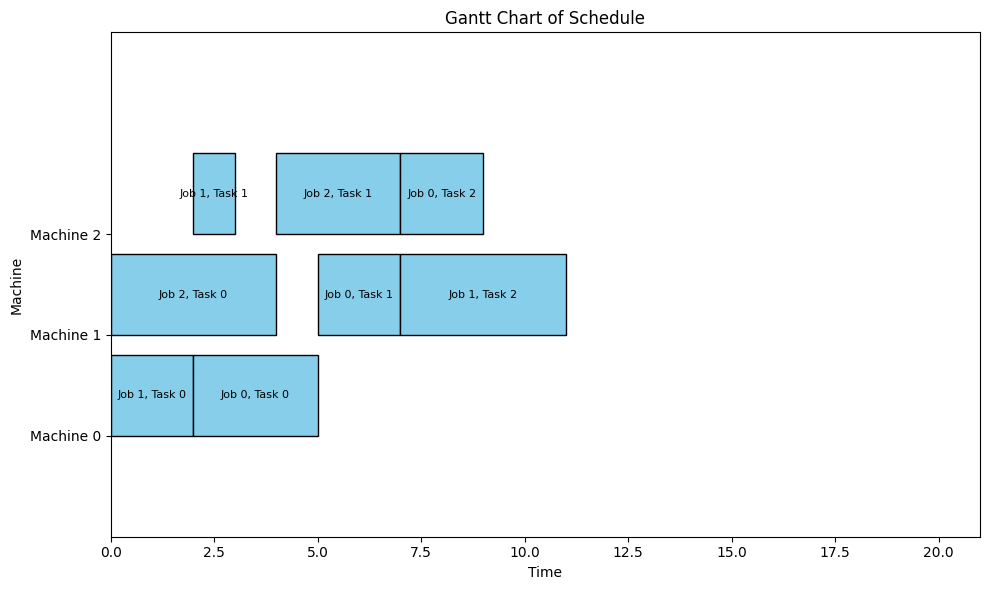

In [123]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Create the figure and axis for the Gantt chart
fig, ax = plt.subplots(figsize=(10, 6))

# Loop over each machine and its assigned tasks to add them to the chart
for machine in assigned_jobs:
    for assigned_task in assigned_jobs[machine]:
        # Construct the name, start time, and duration of the task
        name = f"Job {assigned_task.job}, Task {assigned_task.index}"
        start = assigned_task.start
        duration = assigned_task.duration

        # Add a rectangle patch for the task
        ax.add_patch(
            mpatches.Rectangle(
                (start, machine),  # (x, y) start coordinate
                duration,          # width
                0.8,               # height
                facecolor="skyblue", edgecolor="black"
            )
        )

        # Add text annotation for the task
        ax.text(
            start + duration / 2, machine + 0.4,  # Center text within the rectangle
            name,
            ha='center', va='center', fontsize=8, color='black'
        )

# Set the limits, labels, and title of the chart
ax.set_xlim(0, solver.ObjectiveValue() + 10)
ax.set_ylim(-1, len(all_machines) + 1)  # Assumes `machines` is a list of machine IDs
ax.set_xlabel("Time")
ax.set_ylabel("Machine")
ax.set_title("Gantt Chart of Schedule")

# Set y-ticks to be machine IDs
plt.yticks(range(len(all_machines)), [f"Machine {m}" for m in all_machines])

# Show the plot
plt.tight_layout()
plt.show()
